<a href="https://colab.research.google.com/github/BeniIfland/BeniIfland/blob/main/code/chats/openAI/GeNet_notebooks/New_Results_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
print(IN_COLAB)

True


In [2]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/AUTONET/

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/19DFlX60iwVFe7elp0nLfnc7p_PWvTRYg/AUTONET


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import levene
from scipy.stats import kruskal
from scipy.stats import friedmanchisquare

##Research Questions 1
###To what extent does GPT-4 Vision understand network topology images?

In [4]:
raw_vision_scores = pd.read_csv('./Vision_Experiment_Results/phase1_result_parsed_to_json/phase1_results_parsed_to_json_dict_results_with_fixed_metric_score.csv')
raw_vision_scores.head()

,Unnamed: 0,N1,N2,E1,E2,NPL,NPI,sim_E,sim_EPlabel,Metric_score,Scenario,Platform,Diagram_Type,Temp,Run,Time,Fixed Vision Score
0,0,13,13,12,23,0.923077,0.923077,8,0,0.732358,Adding_Communication_Servers,GNS3,Messy_Layout,0.1,1,0.000549,0.723746
1,1,13,13,12,12,0.923077,0.923077,9,0,0.883173,Adding_Communication_Servers,GNS3,Messy_Layout,1.0,1,0.000541,0.884615
2,2,20,20,19,21,0.950000,0.900000,12,0,0.820536,Adding_DMZ,GNS3,Messy_Layout,0.1,1,0.002436,0.818571
3,3,20,20,19,22,1.000000,0.950000,11,0,0.808750,Adding_DMZ,GNS3,Messy_Layout,1.0,1,0.002587,0.800000
4,4,20,20,19,21,0.950000,0.900000,8,0,0.749107,Adding_DRA,GNS3,Messy_Layout,0.1,1,0.001562,0.742381


##Preprocess

In [5]:
vision_scores = raw_vision_scores[['Scenario','Run','Temp','Platform','Diagram_Type','Metric_score','Time','Fixed Vision Score']]
vision_scores.rename(columns={'Metric_score':'TIUS','Fixed Vision Score':'Fixed TIUS'},inplace=True)
vision_scores['Scenario'] = vision_scores['Scenario'].str.replace('_', ' ')
configuration_scenarios = ['Role Based CLI Access', 'Time Based Access List', 'IP Traffic Export','Transparent IOS Firewall','Basic Zone Based Firewall'] # Replace with your actual scenario names
topology_scenarios = ['Internet Connectivity', 'Adding DMZ', 'Adding DRA', 'Adding Local PCs', 'Adding Communication Servers'] # Replace with your actual scenario names
vision_scores['Type'] = 'Unknown'
# Assign 'Configuration' to the corresponding scenarios
vision_scores.loc[vision_scores['Scenario'].isin(configuration_scenarios), 'Type'] = 'Configuration'
# Assign 'Topology' to the corresponding scenarios
vision_scores.loc[vision_scores['Scenario'].isin(topology_scenarios), 'Type'] = 'Topology'
vision_scores

<ipython-input-5-600424ed93a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vision_scores.rename(columns={'Metric_score':'TIUS','Fixed Vision Score':'Fixed TIUS'},inplace=True)
<ipython-input-5-600424ed93a8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vision_scores['Scenario'] = vision_scores['Scenario'].str.replace('_', ' ')
<ipython-input-5-600424ed93a8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

,Scenario,Run,Temp,Platform,Diagram_Type,TIUS,Time,Fixed TIUS,Type
0,Adding Communication Servers,1,0.1,GNS3,Messy_Layout,0.732358,0.000549,0.723746,Topology
1,Adding Communication Servers,1,1.0,GNS3,Messy_Layout,0.883173,0.000541,0.884615,Topology
2,Adding DMZ,1,0.1,GNS3,Messy_Layout,0.820536,0.002436,0.818571,Topology
3,Adding DMZ,1,1.0,GNS3,Messy_Layout,0.808750,0.002587,0.800000,Topology
4,Adding DRA,1,0.1,GNS3,Messy_Layout,0.749107,0.001562,0.742381,Topology
...,...,...,...,...,...,...,...,...,...
175,Transparent IOS Firewall,1,1.0,PowerPoint,Normal,0.945455,0.002059,0.945455,Configuration
176,Basic Zone Based Firewall,1,0.1,PowerPoint,Normal,0.924342,0.001315,0.926842,Configuration
177,Basic Zone Based Firewall,1,1.0,PowerPoint,Normal,0.924342,0.001362,0.926842,Configuration
178,IP Traffic Export,1,0.1,PowerPoint,Normal,0.929323,0.001989,0.929323,Configuration


##Original TIUS

<ipython-input-29-3409d1404bf8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='TIUS', data=vision_scores, palette='muted')


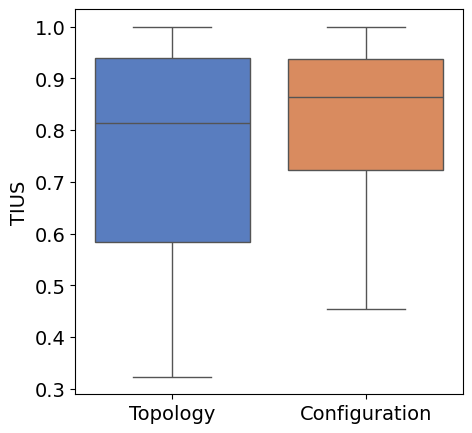

In [29]:
plt.figure(figsize=(5, 5))
plt.rcParams.update({'font.size': 14})
sns.boxplot(x='Type', y='TIUS', data=vision_scores, palette='muted')
# sns.boxplot(x='Type', y='Score', data=data, palette='muted')
# plt.title('Topology Extractor Module Score by Test Case Type')
plt.xlabel('')
plt.ylabel('TIUS',fontsize=14)
plt.show()

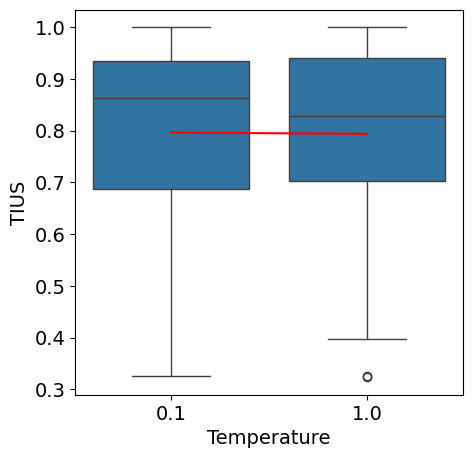

In [30]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='Temp', y='TIUS', data=vision_scores)

means = vision_scores.groupby('Temp')['TIUS'].mean()
x = range(0, len(means))

# Linear interpolation for trend line
slope, intercept = np.polyfit(x, means, 1)
plt.plot(x, slope * x + intercept, color='r', linestyle='-')

# plt.title("Topology Understanding Score vs Temperature Values")
plt.xlabel('Temperature')
plt.ylabel('TIUS')
plt.show()

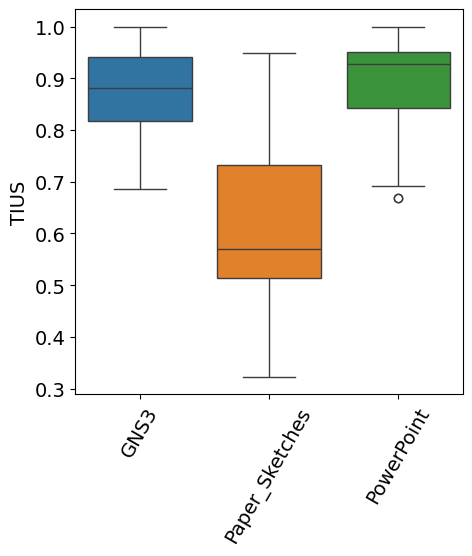

In [35]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='Platform', y='TIUS', data=vision_scores, hue='Platform')
means = vision_scores.groupby('Platform')['TIUS'].mean()
# plt.title("Topology Understanding Score vs Temperature Values")
plt.xlabel('')
plt.ylabel('TIUS')
plt.xticks(rotation=60)
plt.show()

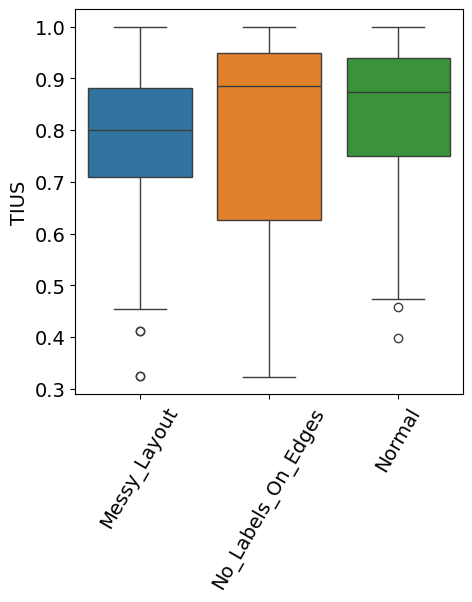

In [36]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='Diagram_Type', y='TIUS', data=vision_scores, hue='Diagram_Type')
means = vision_scores.groupby('Diagram_Type')['TIUS'].mean()
# plt.title("Topology Understanding Score vs Temperature Values")
plt.xlabel('')
plt.ylabel('TIUS')
plt.xticks(rotation=60)
plt.show()

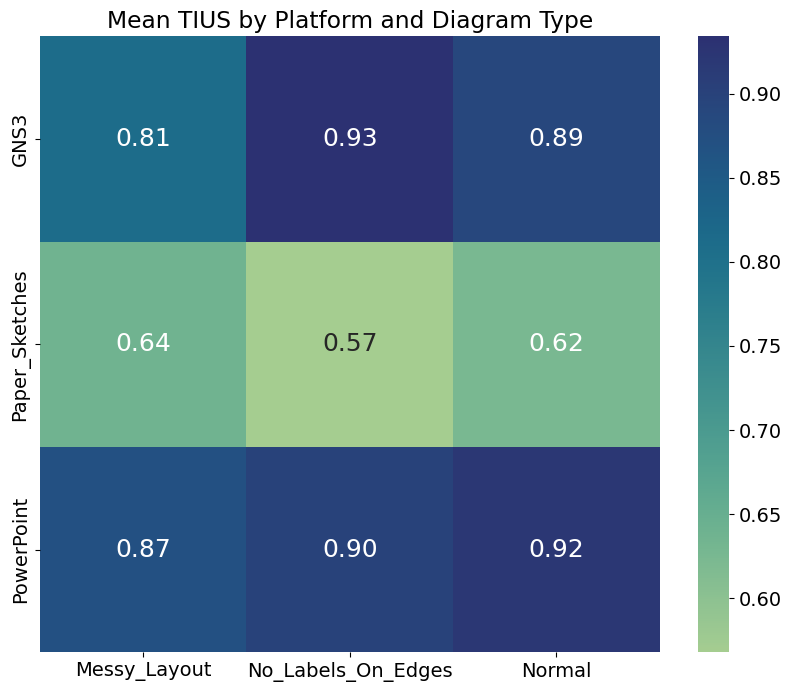

In [41]:
means = vision_scores.groupby(['Platform', 'Diagram_Type'])['TIUS'].mean().unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(means, annot=True, cmap='crest', fmt=".2f",annot_kws={"size": 18})
plt.title('Mean TIUS by Platform and Diagram Type')
plt.xlabel('')
plt.ylabel('')
plt.show()

##Fixed TIUS

<ipython-input-44-3841408ef4fd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Fixed TIUS', data=vision_scores, palette='muted')


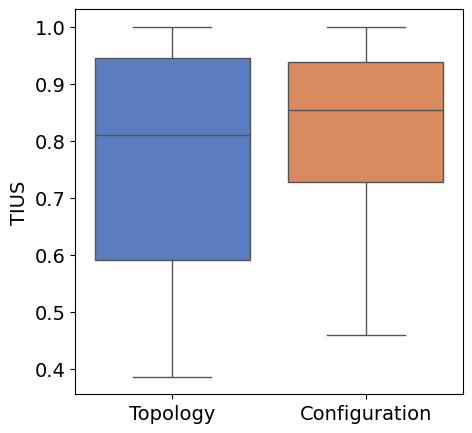

In [44]:
plt.figure(figsize=(5, 5))
plt.rcParams.update({'font.size': 14})
sns.boxplot(x='Type', y='Fixed TIUS', data=vision_scores, palette='muted')
# sns.boxplot(x='Type', y='Score', data=data, palette='muted')
# plt.title('Topology Extractor Module Score by Test Case Type')
plt.xlabel('')
plt.ylabel('Fixed TIUS',fontsize=14)
plt.show()

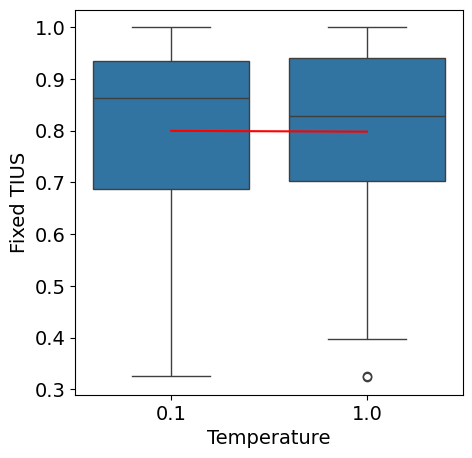

In [45]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='Temp', y='TIUS', data=vision_scores)

means = vision_scores.groupby('Temp')['Fixed TIUS'].mean()
x = range(0, len(means))

# Linear interpolation for trend line
slope, intercept = np.polyfit(x, means, 1)
plt.plot(x, slope * x + intercept, color='r', linestyle='-')

# plt.title("Topology Understanding Score vs Temperature Values")
plt.xlabel('Temperature')
plt.ylabel('Fixed TIUS')
plt.show()

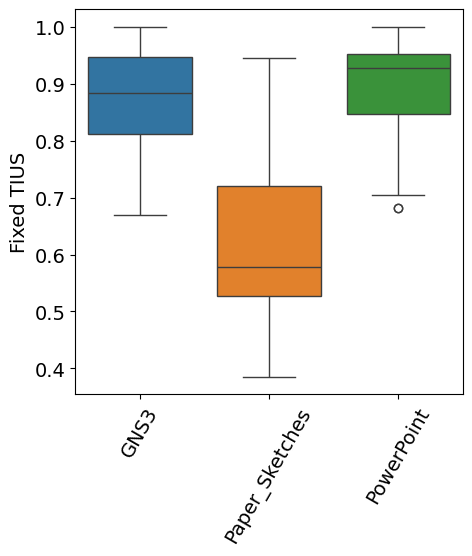

In [46]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='Platform', y='Fixed TIUS', data=vision_scores, hue='Platform')
means = vision_scores.groupby('Platform')['Fixed TIUS'].mean()
# plt.title("Topology Understanding Score vs Temperature Values")
plt.xlabel('')
plt.ylabel('Fixed TIUS')
plt.xticks(rotation=60)
plt.show()

Diagram_Type
Messy_Layout          0.774611
No_Labels_On_Edges    0.805978
Normal                0.815915
Name: Fixed TIUS, dtype: float64


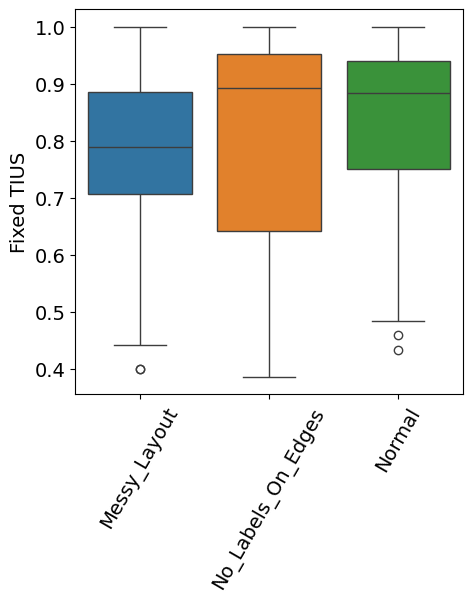

In [77]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='Diagram_Type', y='Fixed TIUS', data=vision_scores, hue='Diagram_Type')
means = vision_scores.groupby('Diagram_Type')['Fixed TIUS'].mean()
# plt.title("Topology Understanding Score vs Temperature Values")
plt.xlabel('')
plt.ylabel('Fixed TIUS')
plt.xticks(rotation=60)
plt.show()

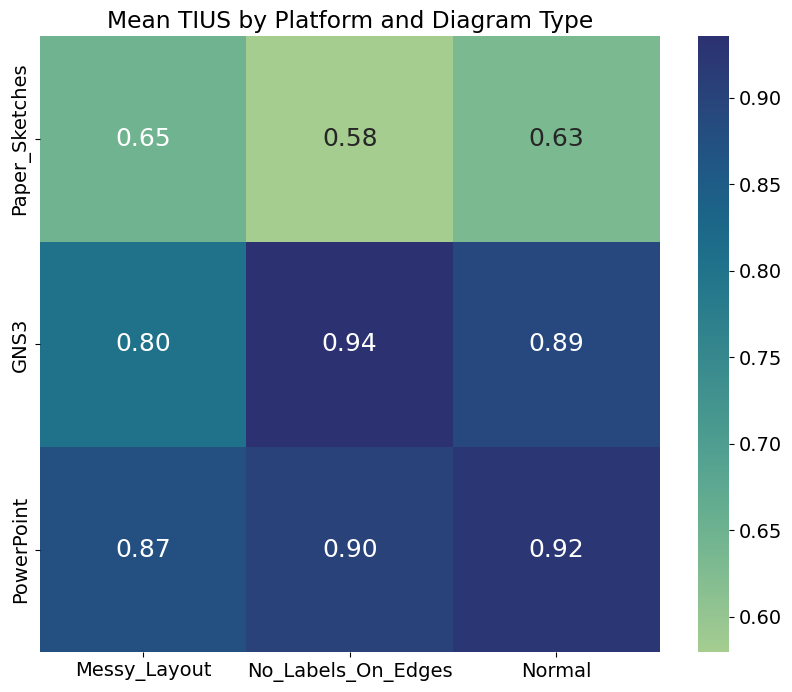

In [78]:
means = vision_scores.groupby(['Platform', 'Diagram_Type'])['Fixed TIUS'].mean().unstack()
sorted_means = means.loc[means.mean(axis=1).sort_values().index, means.mean(axis=0).sort_values().index]

plt.figure(figsize=(10, 8))
sns.heatmap(sorted_means, annot=True, cmap='crest', fmt=".2f",annot_kws={"size": 18})
plt.title('Mean TIUS by Platform and Diagram Type')
plt.xlabel('')
plt.ylabel('')
plt.show()

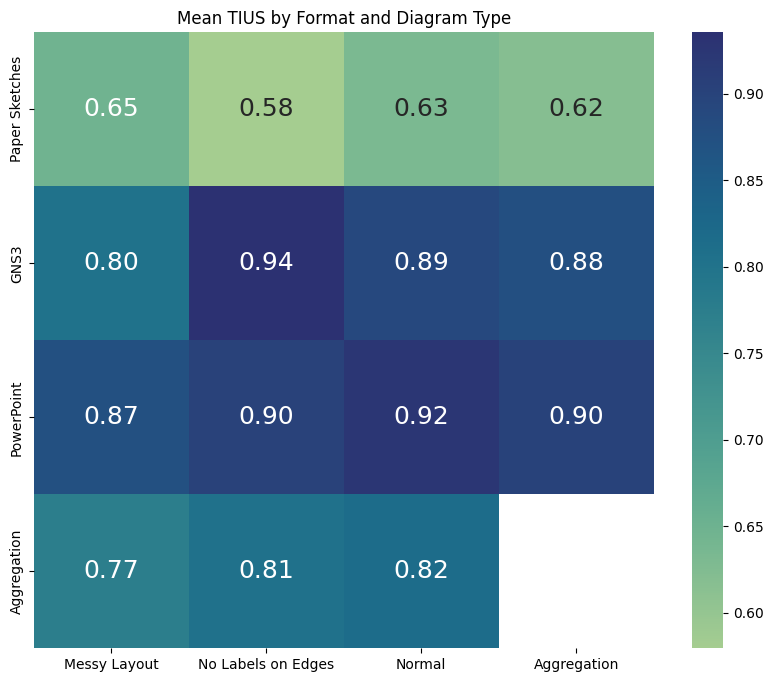

In [6]:
means = vision_scores.groupby(['Platform', 'Diagram_Type'])['Fixed TIUS'].mean().unstack()
sorted_means = means.loc[means.mean(axis=1).sort_values().index, means.mean(axis=0).sort_values().index]
sorted_means['Aggregation'] = vision_scores.groupby('Platform')['Fixed TIUS'].mean()
new_row = vision_scores.groupby('Diagram_Type')['Fixed TIUS'].mean()
sorted_means = pd.concat([sorted_means, pd.DataFrame([new_row], index=['Aggregation'])])
sorted_means.rename(columns={'No_Labels_On_Edges':'No Labels on Edges','Messy_Layout':'Messy Layout'},inplace=True)
sorted_means.index = sorted_means.index.where(sorted_means.index != 'Paper_Sketches', 'Paper Sketches')
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_means, annot=True, cmap='crest', fmt=".2f",annot_kws={"size": 18})
plt.title('Mean TIUS by Format and Diagram Type')
plt.xlabel('')
plt.ylabel('')
plt.show()

##RQ1 Statistical Tests

Levene's Variance Equality test for all groups alltogether

In [51]:
# Perform Levene's test
# Group data by 'Platform' and 'Diagram_Type'
groups = vision_scores.groupby(['Platform', 'Diagram_Type'])['Fixed TIUS']

# Extract data for each group
data = [group.values for _, group in groups]

# Perform Levene's test
statistic, p_value = levene(*data)

print(f"Levene's Test Statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Variances are significantly different.")
else:
    print("Variances are not significantly different.")

Levene's Test Statistic: 4.174630963918792
P-value: 0.00013871640221243173
Variances are significantly different.


Pairwise Leene's test

<ipython-input-170-456d37e699e2>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = vision_scores.groupby(['Platform', 'Diagram_Type'])['Fixed TIUS']


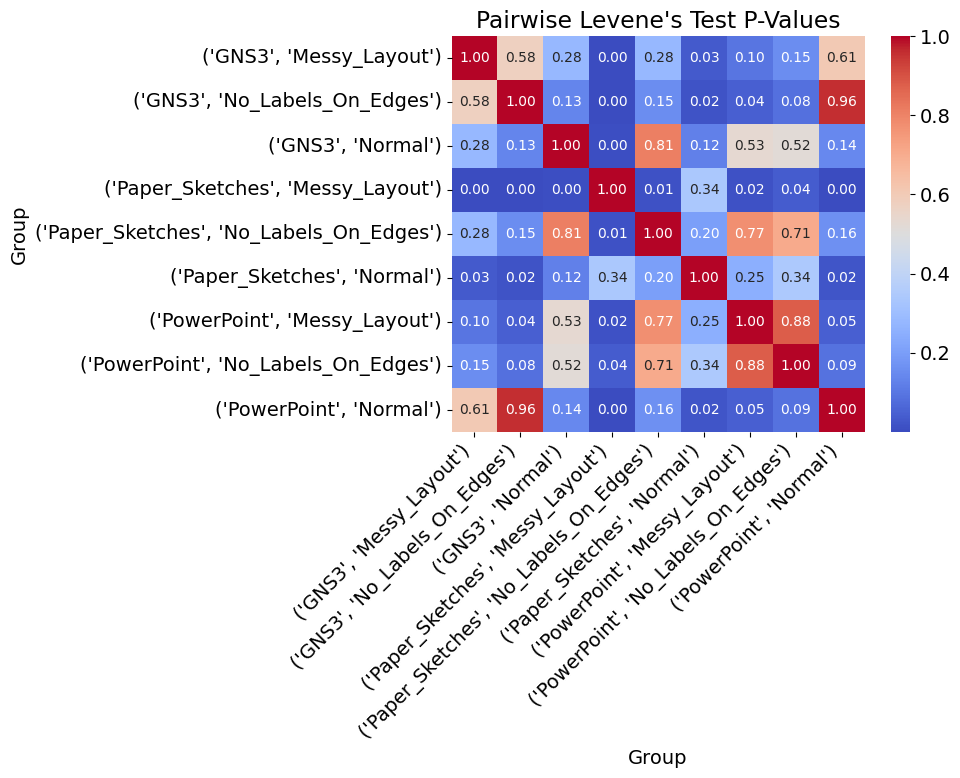

In [170]:
groups = vision_scores.groupby(['Platform', 'Diagram_Type'])['Fixed TIUS']

# Create a pivot table to store p-values
combinations = list(groups.groups.keys())
n = len(combinations)
p_values = np.zeros((n, n))

# Perform pairwise Levene's test and store the p-values
for i in range(n):
    for j in range(i, n):  # Only calculate upper triangle
        group1_name = combinations[i]
        group2_name = combinations[j]
        group1_data = vision_scores[(vision_scores['Platform'] == group1_name[0]) & (vision_scores['Diagram_Type'] == group1_name[1])]['Fixed TIUS']
        group2_data = vision_scores[(vision_scores['Platform'] == group2_name[0]) & (vision_scores['Diagram_Type'] == group2_name[1])]['Fixed TIUS']

        if i != j:
            _, p_value = levene(group1_data, group2_data)
        else:
            p_value = 1  # Variance is identical with itself

        p_values[i, j] = p_values[j, i] = p_value

# Create a DataFrame for the heatmap
p_values_df = pd.DataFrame(p_values, index=combinations, columns=combinations)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_values_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, xticklabels=True, yticklabels=True,annot_kws={"size": 10})
plt.title("Pairwise Levene's Test P-Values")
plt.xlabel("Group")
plt.ylabel("Group")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Kruskal-Wallis Test - compare means across one random variable**

Format:

In [144]:
# Perform Kruskal-Wallis test
groups = vision_scores.groupby('Platform')['Fixed TIUS']
statistic, p_value = kruskal(*[group.values for _, group in groups])

print(f"Kruskal-Wallis Test Statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference in means across different Formats.")
else:
    print("There is no statistically significant difference in means across different Formats.")

Kruskal-Wallis Test Statistic: 88.66272703485345
P-value: 5.586418267024393e-20
There is a statistically significant difference in means across different Formats.


In [169]:
groups = vision_scores.groupby('Diagram_Type')['Fixed TIUS']
statistic, p_value = kruskal(*[group.values for _, group in groups])

print(f"Kruskal-Wallis Test Statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("There is a statistically significant difference in means across different diagram variants.")
else:
    print("There is no statistically significant difference in means across different diagram variants.")

Kruskal-Wallis Test Statistic: 5.22133505233051
P-value: 0.07348547391057247
There is no statistically significant difference in means across different diagram variants.


<ipython-input-169-35f2ca37d513>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = vision_scores.groupby('Diagram_Type')['Fixed TIUS']


In [154]:
# Make sure the independent variables are categorical
vision_scores['Platform'] = vision_scores['Platform'].astype('category')
vision_scores['Diagram_Type'] = vision_scores['Diagram_Type'].astype('category')

# Reshape data to get all levels of 'Platform' and 'Diagram_Type'
# Here, I'm assuming you want to compare within these groups.

# Group by both 'Platform' and 'Diagram_Type' and get the dependent variable ('Fixed TIUS') for each combination
grouped = vision_scores.groupby(['Platform', 'Diagram_Type'])['Fixed TIUS'].apply(list)

# Prepare data for Friedman test (each group will be one list of samples)
data = [group for group in grouped]

# Perform the Friedman test
stat, p_value = friedmanchisquare(*data)

print("Friedman test statistic:", stat)
print("P-value:", p_value)


Friedman test statistic: 99.64731182795707
P-value: 5.0398584450727544e-18


<ipython-input-154-4aedbb203be9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vision_scores['Platform'] = vision_scores['Platform'].astype('category')
<ipython-input-154-4aedbb203be9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vision_scores['Diagram_Type'] = vision_scores['Diagram_Type'].astype('category')
<ipython-input-154-4aedbb203be9>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current be

<ipython-input-168-8ea5b28469c3>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = vision_scores.groupby(['Platform', 'Diagram_Type'])['Fixed TIUS']


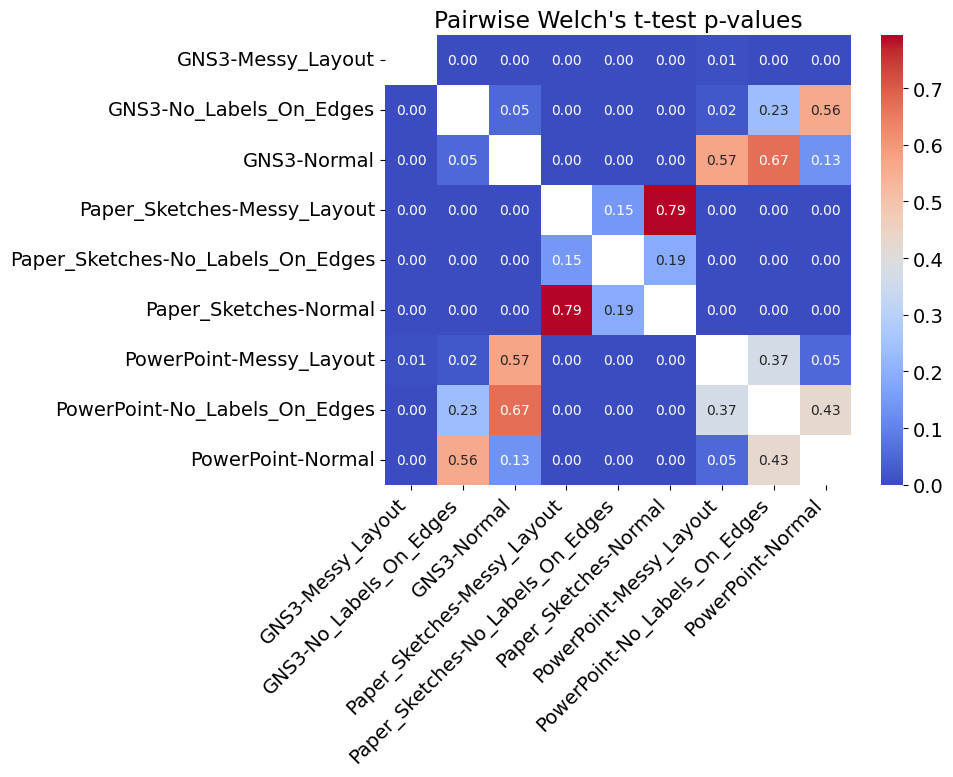

In [168]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

# Group data by 'Platform' and 'Diagram_Type'
groups = vision_scores.groupby(['Platform', 'Diagram_Type'])['Fixed TIUS']

# Create a list of all unique group combinations
combinations = list(groups.groups.keys())
num_combinations = len(combinations)

# Perform pairwise Welch's t-tests
results = {}
p_values = np.full((num_combinations, num_combinations), np.nan)  # Matrix to store p-values

for i in range(num_combinations):
    for j in range(i + 1, num_combinations):
        group1_name = combinations[i]
        group2_name = combinations[j]

        group1_data = vision_scores[
            (vision_scores['Platform'] == group1_name[0]) &
            (vision_scores['Diagram_Type'] == group1_name[1])
        ]['Fixed TIUS']

        group2_data = vision_scores[
            (vision_scores['Platform'] == group2_name[0]) &
            (vision_scores['Diagram_Type'] == group2_name[1])
        ]['Fixed TIUS']

        t_stat, p_val = ttest_ind(group1_data, group2_data, equal_var=False)  # Welch's t-test
        results[(group1_name, group2_name)] = (t_stat, p_val)
        p_values[i, j] = p_val
        p_values[j, i] = p_val  # Symmetric matrix

# Convert the combinations to readable labels for the heatmap
labels = [f"{platform}-{diagram_type}" for platform, diagram_type in combinations]

# Create a DataFrame for the heatmap
p_values_df = pd.DataFrame(p_values, index=labels, columns=labels)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(p_values_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True,
            xticklabels=labels, yticklabels=labels,annot_kws={"size": 10})
plt.title("Pairwise Welch's t-test p-values")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
